# Building a dataset
A labeled dataset was needed to train and validate a model. Using MNIST dataset was tempting however it does not contain math operators. Since math operators are required in the dataset, it was probably better to generate the digits in the same process. The same 20 by 20 "white" character framed inside a 28 by 28 black frame was chosen for compatibility with MNIST samples (no harm in some future-proofing the design). The major difference is that centering the character within the frame was not done based on the mass-weighted center of the character but rather by padding the non-black area evenly on all four sides.

## Design process
A simple 3-phase approach was chosen for generating a labeled dataset.

### Phase 1: generating initial pages of 4 styles of "handwriting"
The goal was to have:
- 1 page per style
- 16 many-character lines per page, 1 class of characters per line

The characters within a each style and class **could be identical** as long as there were many of them per line. The procedure was:

1. some sans-serif fonts were chosen for digits and operators that resemble a very, very clean handwriting
    - 3 different mixed-fonts set of characters were chosen and called "style A", "style B" and "style C"
2. for each style, the 16 characters from set { 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, +, -, ×, /, (, ) } were typed each on its own new line of text in Inkscape
3. each character was copy/pasted in increasing block sizes within its line to extend the number of total same-class characters of the same style
    - generous spacing between characters and lines was set to avoid any horizontal or vertical overlap, especially after augmentation
4. the 3 blocks of 16 lines were exported as separate PNG images at a resolution that resulted in about 75 px line height for the tallest characters like "/" and "(" to as little as 5 px line height for a "-"
    - this concluded the character manipulations in vector format using Inkscape
    - the resulting large images are provided as [page_A.png](images/page_A.png), [page_B.png](images/page_B.png) and [page_C.png](images/page_C.png)
5. the fourth style was added which started as a [photograph](images/page_D.jpg) of characters hand-written on a sheet of paper
    - note: switched to using GIMP for manipulating bitmap images
    - the hand-written sample was small so was horizontally stacked with its own copies to extend to the dimensions of other styles
    - note: some augmentation was already done here while copy/pasting, namely flipping and/or rotating long lines of characters from { 0, 6, 8, 9, +, -, x, /, (, ) } before hstacking them together
    - the resulting large image is provided as [page_D.png](images/page_D.png)

### Phase 2: data augmentation
Instead of programming image augmentation per character basis, a different approach was chosen. The goal was to efficiently diversify the members of each class in huge batches all at once while not loosing their class label information. The procedure was:

1. all 4 images were imported as separate layers into a multi-layer image
2. characters in all 4 layers were randomly distorted by:
    - generating a displacement map:
        - generating [simplex noise](images/simplex_noise_settings.png)
        - applying [Gaussian blur](images/gaussian_blur_settings.png)
        - adjusting the [white level](images/curves_settings.png)
        - a _highly_ compressed JPEG [sample](images/xy_displacement_map.jpg) is provided for reference
    - applying displacement mapping to all 4 layers of the image ([parameters](images/xy_displacement_settings.png) for reference)
3. distorted characters in all 4 layers were squeezed and stretched along the y-axis by:
    - generating another displacement map using a gradient tool
        - a _highly_ compressed JPEG [sample](images/y_displacement_map.jpg) is provided for reference
    - applying displacement mapping to all 4 layers of the image ([parameters](images/y_displacement_settings.png) for reference)
4. all 4 layers of the image were duplicated multiple times and the copies were skewed left and right to various degrees
    - all the resulting layers of the image were batch-exported to separate PNG images featuring:
        - 11 levels of "skewiness" (none, 5 left, 5 right) for each of the styles A, B and C
        - 7 levels of "skewiness" (none, 2 left, 4 right) for handwritten style D (inherently more diverse)
        - all 40 pages are provided in the [images](images) subfolder (names starting with "base_")

This kind of batch-level data augmentation (at least for the purpose of simulating handwriting by applying distortions) has proved to be time-efficient and most importantly, yielded quickly and easily visually verifiable results.

### Phase 3: data processing
This phase is very similar to preprocessing that an image of an expression will go through in order to extract the characters from the image and pass them to a classifier. The only difference here is that the 40 pages of characters generated in the phase 2 all have single-class lines in the same known order. Attaching a true class label to each extracted character is thus made to be a trivial task. The rest of the notebook does just that, with some data analysis of the resulting labeled dataset.

In [1]:
import os
import re
import sys
import pickle
import hashlib
import numpy as np
import pandas as pd
import cv2 as cv
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
sns.set(rc={'figure.dpi': 72, 'savefig.dpi': 72})
sns.set_context('notebook')

### Original dataset-building functions
What follows are the original functions used to (pre)process the 40 pages of synthetic data. Some of them are prototypes of the functions meant for real data preprocessing. The later need more robustness but given that some crucial properties of synthetic data are well defined, these simple prototypes will serve the purpose for now.

Documenting prototypes was not of a great concern since they were to be used only once in this notebook. Those that were further tailored to real-world data requirements are well documented in a separate module.

In [2]:
WHITE_SPREAD = 5.5
MAX_INK_VALUE = 102_000

def showhist(img):
    plt.hist(img.ravel(), 256, (0, 256))
    plt.show()

def desaturate(img):
    return img.min(axis=2)

def autostretch(img, black=None, white=None):
    img_out = img.astype(float)
    if black is None:
        black = img_out.min()
    if white is None:
        white = img_out.max()
    img_out = np.round((img_out - black) / (white - black) * 255)
    img_out[img_out < 0] = 0
    return img_out.astype(np.uint8)
    
def autothresh(img):
    img_out = autostretch(img).astype(float)
    whitepoint = np.median(img_out) - 3 * img_out.std()
    mask = img_out <= whitepoint
    blackpoint = np.median(img_out[mask]) * 2
    thresh = (blackpoint + whitepoint) * 0.5
    img_out[img_out > thresh] = 255
    img_out[img_out <= thresh] = 0
    return img_out.astype(np.uint8)

def get_hmask(img):
    return (img != 255).any(axis=1)
def get_vmask(img):
    return (img != 255).any(axis=0)

def split_mask(mask):
    # extend by a single False
    mask1 = np.array([*mask, False], dtype=bool)
    # prepend by a single False
    mask2 = np.array([False, *mask], dtype=bool)
    # offset by one and XOR to detect transitions from False to True and vice versa
    transitions = np.logical_xor(mask1, mask2)
    transitions = np.flatnonzero(transitions)
    # extract the submasks
    submasks = []
    for idx in range(0, len(transitions), 2):
        submask = np.zeros(mask.shape)
        submask[transitions[idx]:transitions[idx + 1]] = 1
        submasks.append(submask.astype(bool))
    return submasks

def invert_bw(img):
    return 255 - img

def framechar(char):
    max_dim = max(char.shape)
    scale = 20 / max_dim
    char = cv.resize(char, (0, 0), fx=scale, fy=scale)
    char = invert_bw(char)
    height, width = char.shape
    framed = np.zeros((28, 28), dtype=np.uint8)
    top = (28 - height) // 2
    left = (28 - width) // 2
    framed[top:(top + height), left:(left + width)] = char
    return framed

def get_filenames(folder, regex):
    pagename_re = re.compile(regex)
    pages = []
    script_styles = []
    script_substyles = []

    for filename in os.listdir(folder):
        if (match := pagename_re.match(filename)):
            script_styles.append(match.group(2))
            script_substyles.append(match.group(1))
            pagefilename = os.path.join(folder, filename)
            pages.append(pagefilename)
    return script_styles, script_substyles, pages

def get_img_sig(img):
    img_string = ' '.join(img.ravel().astype(str))
    img_string_hashed = hashlib.md5(img_string.encode('utf-8')).hexdigest()
    return img_string_hashed

def get_ink_fraction(img):
    return img.sum() / MAX_INK_VALUE

def get_outliers(df):
    idxs = []
    for script_substyle in df.script_substyle.unique():
        for label in df.label.unique():        
            subdf = df.loc[(df.script_substyle == script_substyle) & (df.label == label)]
            Q1 = subdf.ink_fraction.quantile(0.25)
            Q3 = subdf.ink_fraction.quantile(0.75)
            IQR = Q3 - Q1
            low = Q1 - 1.5 * IQR
            high = Q3 + 1.5 * IQR
            idxs.extend(list(subdf.loc[(subdf.ink_fraction < low) | (subdf.ink_fraction > high)].index))
    return idxs

In [3]:
base_images_dir = 'images'
dataset_dir = 'dataset'

# a list of character MD5 digests to be used in filenames
char_sigs = []

dataset = {'filename': [],
           'array' : [],
           'label': [],
           'label_desc': [],
           'script_style': [],
           'script_substyle': [],
           'ink_fraction': [],
          }

labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '+', '-', 'x', '/', '(', ')']
labels_POSIX = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '0', 'plus', 'minus', 'x', 'slash', 'lpar', 'rpar']

script_styles, script_substyles, pages = get_filenames(base_images_dir, r'^base_(([ABCD]).*)\.png$')
for script_style, script_substyle, filename in zip (script_styles, script_substyles, pages):
    print(f'{script_substyle = }')
    img = cv.imread(filename, 1)
    if img is None:
        sys.exit(f'Could not read: {filename}')

    img2 = desaturate(img)

    hsubmasks = split_mask(get_hmask(img2))

    # this part of code is the skeleton for the extractor.py module
    for line_idx, hsubmask in enumerate(hsubmasks):
        label = labels[line_idx]
        label_POSIX = labels_POSIX[line_idx]

        label_dir = os.path.join(dataset_dir, label_POSIX)
        os.makedirs(label_dir, exist_ok=True)

        line = img2[hsubmask]
        vsubmasks = split_mask(get_vmask(line))

        for char_idx, vsubmask in enumerate(vsubmasks):
            char = line[:, vsubmask]
            charmasks = split_mask(get_hmask(char))
            charmask = sorted(charmasks, key=lambda x: x.sum(), reverse=True)[0]
            char = char[charmask]

            # get the unique signature for the char (MD5 digest of the caracter array values)
            char_sig = get_img_sig(char)
            char_sigs.append(char_sig)

            char = framechar(char)

            filename = os.path.join(label_dir, f'{char_sig}.png')
            cv.imwrite(filename, char)
            
            dataset['filename'].append(filename)
            dataset['array'].append(char)
            dataset['label'].append(line_idx)
            dataset['label_desc'].append(label)
            dataset['script_style'].append(script_style)
            dataset['script_substyle'].append(script_substyle)
            dataset['ink_fraction'].append(get_ink_fraction(char))

script_substyle = 'D2L'
script_substyle = 'A1R'
script_substyle = 'B1R'
script_substyle = 'A4L'
script_substyle = 'B2L'
script_substyle = 'C2L'
script_substyle = 'C5R'
script_substyle = 'B2R'
script_substyle = 'A3L'
script_substyle = 'A4R'
script_substyle = 'C1L'
script_substyle = 'D3R'
script_substyle = 'A2L'
script_substyle = 'B4R'
script_substyle = 'B4L'
script_substyle = 'D2R'
script_substyle = 'C4L'
script_substyle = 'C2R'
script_substyle = 'C'
script_substyle = 'C3L'
script_substyle = 'A'
script_substyle = 'A5L'
script_substyle = 'B'
script_substyle = 'B1L'
script_substyle = 'D1L'
script_substyle = 'D1R'
script_substyle = 'C1R'
script_substyle = 'C3R'
script_substyle = 'B5R'
script_substyle = 'C5L'
script_substyle = 'A1L'
script_substyle = 'D4R'
script_substyle = 'B3R'
script_substyle = 'B3L'
script_substyle = 'A2R'
script_substyle = 'A5R'
script_substyle = 'C4R'
script_substyle = 'B5L'
script_substyle = 'A3R'
script_substyle = 'D'


In [4]:
df = pd.DataFrame(dataset)
df

,filename,array,label,label_desc,script_style,script_substyle,ink_fraction
0,dataset/1/344cbd788a7f3d3d6dfcc1740d93786b.png,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,1,D,D2L,0.169000
1,dataset/1/2f3077c3d55f8079c4e6364169ed5669.png,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,1,D,D2L,0.173882
2,dataset/1/18eda8f7a9d70c93a49ecb82603d91ad.png,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,1,D,D2L,0.153608
3,dataset/1/afeef2b5afdceb14de7d64e5fbcf2803.png,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,1,D,D2L,0.133118
4,dataset/1/bc658871d5869a9558b0472f577b861e.png,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,1,D,D2L,0.158961
...,...,...,...,...,...,...,...
120745,dataset/rpar/2e5b248c291af840604e267bb7bdc3cd.png,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",15,),D,D,0.082314
120746,dataset/rpar/0ec3471d027a9fc0f963ab5fe74d7a4a.png,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",15,),D,D,0.083422
120747,dataset/rpar/6f14c7c9053a9b398f1f1354701063be.png,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",15,),D,D,0.076598
120748,dataset/rpar/f308eed02c47aec7bd4b4110e70dcaee.png,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",15,),D,D,0.108059


In [5]:
print(f'duplicates count = {df.filename.duplicated().sum()}')

duplicates count = 0


In [6]:
# find outliers based on ink fraction and move them to a subfolder for closer inspection
outliers = get_outliers(df)
for path1 in df.loc[outliers, 'filename'].values:
    path2 = re.sub(dataset_dir, os.path.join(dataset_dir, 'outliers'), path1)
    os.renames(path1, path2)

print(f'outliers count = {len(outliers)}')
print(f'outliers fraction = {len(outliers)/len(df):.2%}')

outliers count = 734
outliers fraction = 0.61%


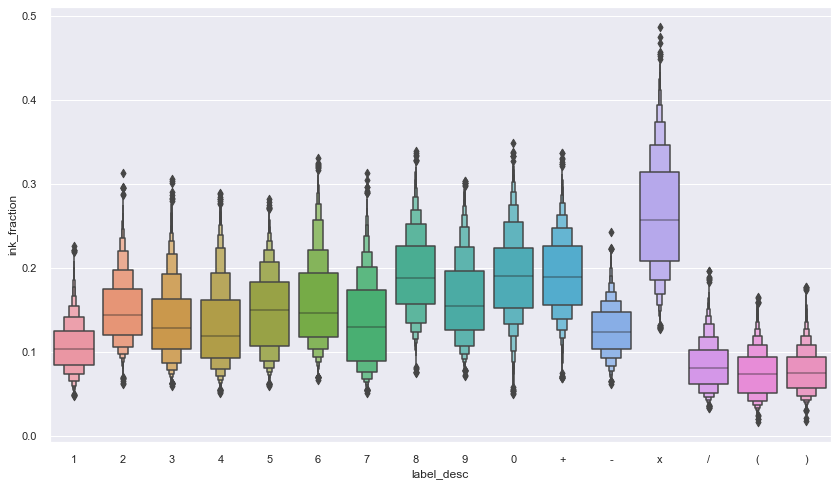

In [7]:
plt.figure(figsize=(14, 8))
_ = sns.boxenplot(data=df, x='label_desc', y='ink_fraction')

#### Chart 1
The chart clearly shows different ink fraction ranges between character classes.

In [8]:
# drop outliers
df = df.loc[~df.index.isin(outliers)].reset_index(drop=True)

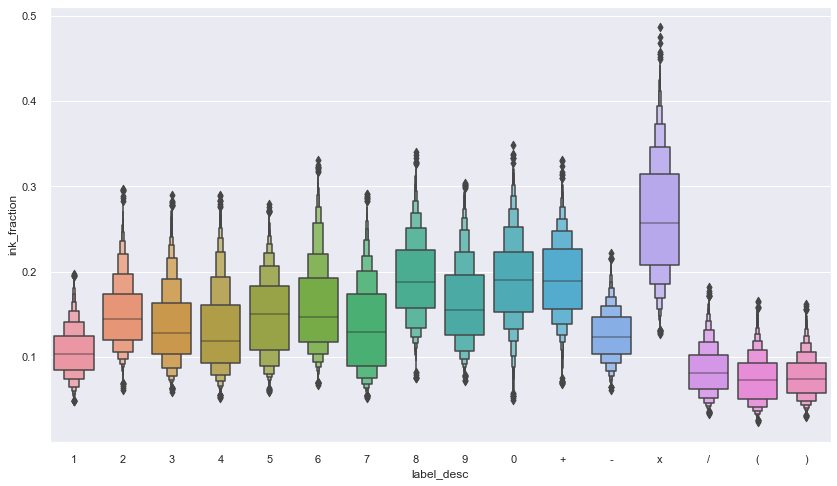

In [9]:
plt.figure(figsize=(14, 8))
_ = sns.boxenplot(data=df, x='label_desc', y='ink_fraction')

#### Chart 2
After dropping the outliers one can see that some upper extreme values shrank down a bit but not by much. This is in accordance with very low fraction of outliers detected and removed from an otherwise massive dataset.

Among 734 outliers removed from the dataset, visual inspection revealed only 12 were true unrecognizable smudges. The rest could have easily pass as valid samples. Since the images were stored in PNG format, all 12 true outliers had either the largest or the smallest size (in bytes) of any other "outlier" in their class. This made it easy to inspect a few smallest and largest files among each of the labels in the rest of the dataset. No smudges or otherwise unrecognizable "characters" were found.

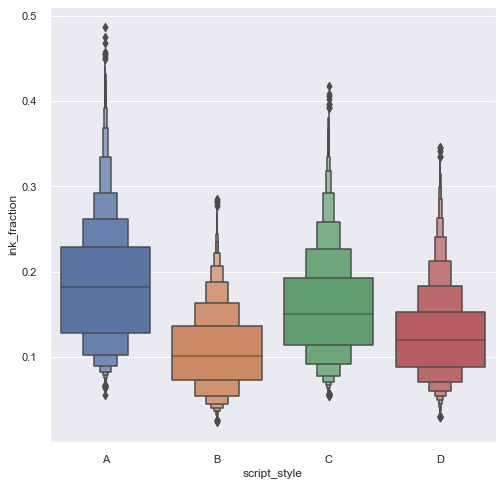

In [10]:
plt.figure(figsize=(8, 8))
_ = sns.boxenplot(data=df.sort_values('script_style'), x='script_style', y='ink_fraction')

#### Chart 3
It seems that styles B and C fit pretty close by the ink fraction range to this particular handwritten style D. However, there are certainly thicker pens and heavier hands out there that could find a closer match in style A.

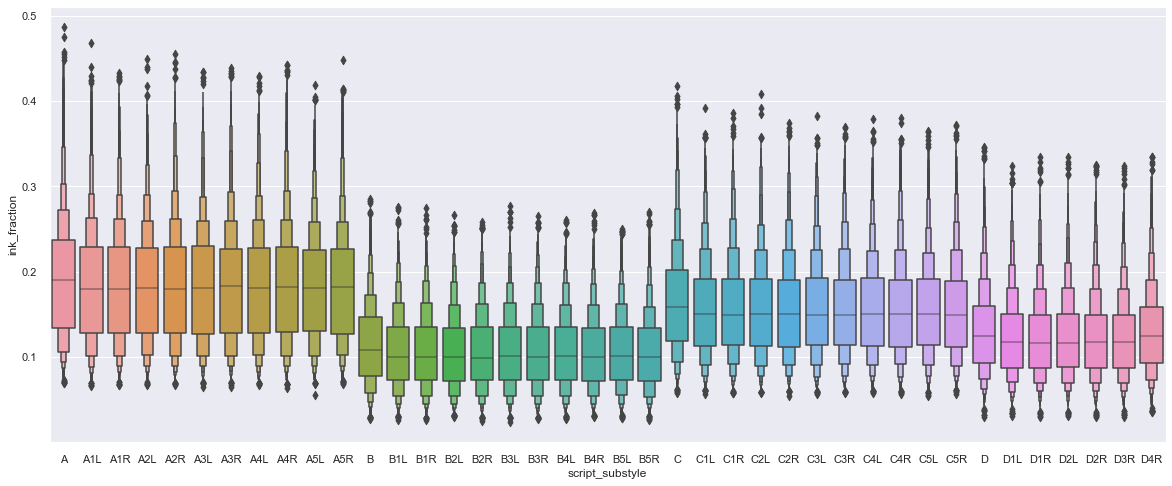

In [11]:
plt.figure(figsize=(20, 8))
_ = sns.boxenplot(data=df.sort_values('script_substyle'), x='script_substyle', y='ink_fraction')

#### Chart 4
To no surprise, no major difference in ink fraction can be distinguished among substyles of any style.

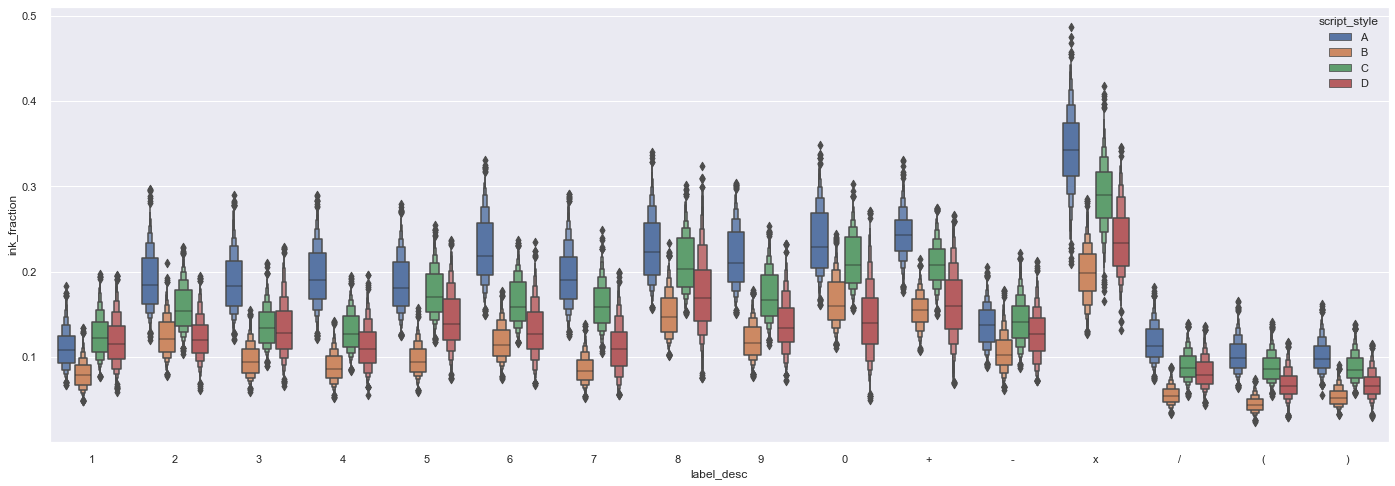

In [12]:
plt.figure(figsize=(24, 8))
_ = sns.boxenplot(data=df, x='label_desc', y='ink_fraction', hue="script_style", hue_order=['A', 'B', 'C', 'D'])

#### Chart 5
Compared to the Chart 3 no big surprises were found by controlling for the class label. Yes, some classes show discrepancies with the aggregate trend but nothing worth investigating.

In [13]:
X = np.concatenate(df.array).reshape(len(df), 28, 28)
y = df.label.values
X.shape, y.shape

((120016, 28, 28), (120016,))

In [14]:
custom_math_dataset = (X, y)
with open('math_dataset_md_1.0.pkl', 'wb') as file:
    pickle.dump(custom_math_dataset, file)

In [15]:
!gzip math_dataset_md_1.0.pkl

In [16]:
!mv math_dataset_md_1.0.pkl.gz ../dataset